# 1. Import Libraries:

In [1]:
import pandas as pd
import numpy as np
import re
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity

import re
from collections import Counter
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
from wordcloud import WordCloud


stop_words = set(stopwords.words('english'))



[nltk_data] Downloading package stopwords to /usr/share/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


# 2. Load Dataset:

- It contains two set of dataset; resume and job description
- Resume.csv contains ID, resume and category
- training_data.csv contains company name, job description and position title

In [2]:
# Resume dataset:
resumes_df = pd.read_csv("/kaggle/input/resume-and-job-description/Resume.csv")

resumes_df.head()


,ID,Resume_str,Resume_html,Category
0,16852973,HR ADMINISTRATOR/MARKETING ASSOCIATE\...,"<div class=""fontsize fontface vmargins hmargin...",HR
1,22323967,"HR SPECIALIST, US HR OPERATIONS ...","<div class=""fontsize fontface vmargins hmargin...",HR
2,33176873,HR DIRECTOR Summary Over 2...,"<div class=""fontsize fontface vmargins hmargin...",HR
3,27018550,HR SPECIALIST Summary Dedica...,"<div class=""fontsize fontface vmargins hmargin...",HR
4,17812897,HR MANAGER Skill Highlights ...,"<div class=""fontsize fontface vmargins hmargin...",HR


In [3]:
# job description dataset
jobs_df = pd.read_csv("/kaggle/input/resume-and-job-description/training_data.csv")

jobs_df.head()


,company_name,job_description,position_title,description_length,model_response
0,Google,minimum qualifications\nbachelors degree or eq...,Sales Specialist,2727,"{\n ""Core Responsibilities"": ""Responsible fo..."
1,Apple,description\nas an asc you will be highly infl...,Apple Solutions Consultant,828,"{\n ""Core Responsibilities"": ""as an asc you ..."
2,Netflix,its an amazing time to be joining netflix as w...,Licensing Coordinator - Consumer Products,3205,"{\n ""Core Responsibilities"": ""Help drive bus..."
3,Robert Half,description\n\nweb designers looking to expand...,Web Designer,2489,"{\n ""Core Responsibilities"": ""Designing webs..."
4,TrackFive,at trackfive weve got big goals were on a miss...,Web Developer,3167,"{\n ""Core Responsibilities"": ""Build and layo..."


# 3. Exploratory Data Analysis (EDA):

In [4]:
print("Number of resumes:", len(resumes_df))

print("Number of job descriptions:", len(jobs_df))

Number of resumes: 2484
Number of job descriptions: 853


In [5]:
# Count of resumes per category
category_counts = resumes_df['Category'].value_counts().reset_index()
category_counts.columns = ['Category', 'Count']
print(category_counts)


                  Category  Count
0   INFORMATION-TECHNOLOGY    120
1     BUSINESS-DEVELOPMENT    120
2                 ADVOCATE    118
3                     CHEF    118
4              ENGINEERING    118
5               ACCOUNTANT    118
6                  FINANCE    118
7                  FITNESS    117
8                 AVIATION    117
9                    SALES    116
10                 BANKING    115
11              HEALTHCARE    115
12              CONSULTANT    115
13            CONSTRUCTION    112
14        PUBLIC-RELATIONS    111
15                      HR    110
16                DESIGNER    107
17                    ARTS    103
18                 TEACHER    102
19                 APPAREL     97
20           DIGITAL-MEDIA     96
21             AGRICULTURE     63
22              AUTOMOBILE     36
23                     BPO     22


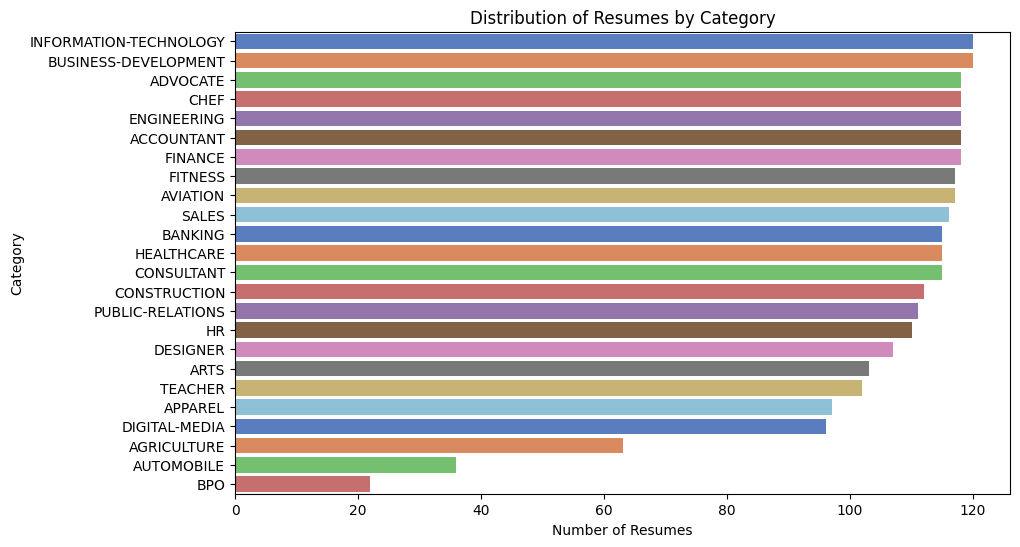

In [6]:
plt.figure(figsize=(10,6))
sns.barplot(x='Count', y='Category', data=category_counts, palette='muted')
plt.title("Distribution of Resumes by Category")
plt.xlabel("Number of Resumes")
plt.ylabel("Category")
plt.show()


In [7]:
# Count job descriptions per position title
job_title_counts = jobs_df['position_title'].value_counts().reset_index()
job_title_counts.columns = ['Position Title', 'Count']

print(job_title_counts)


                                       Position Title  Count
0                                     Sales Associate      9
1                              Retail Sales Associate      9
2                                     Project Manager      7
3                                     Inventory Clerk      6
4                               Systems Administrator      6
..                                                ...    ...
720  Senior Sales Marketing Specialist (Programmatic)      1
721                   Sales and Marketing Coordinator      1
722                       Growth Marketing Specialist      1
723                             Marketing Coordinator      1
724           Program Director / Supervising Attorney      1

[725 rows x 2 columns]


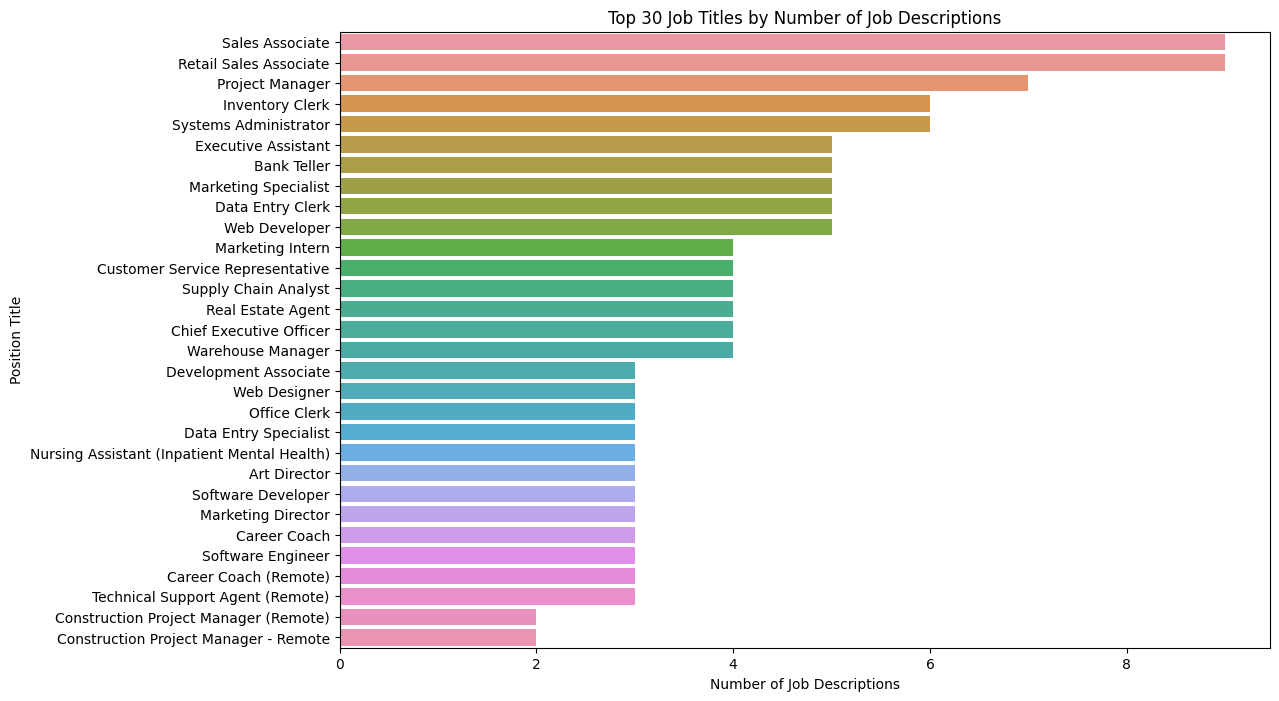

In [8]:
plt.figure(figsize=(12,8))
sns.barplot(
    x='Count', 
    y='Position Title', 
    data=job_title_counts.head(30)
)
plt.title("Top 30 Job Titles by Number of Job Descriptions")
plt.xlabel("Number of Job Descriptions")
plt.ylabel("Position Title")
plt.show()


In [9]:
def top_words(text_series, n=20):
    all_text = ' '.join(text_series).lower()
    # Remove punctuation and special characters
    all_text = re.sub(r'[^a-z\s]', '', all_text)
    words = all_text.split()
    # Remove NLTK stopwords
    words = [w for w in words if w not in stop_words]
    return Counter(words).most_common(n)

print("Top Resume Words:", top_words(resumes_df['Resume_str']))
print("\nTop Job Description Words:", top_words(jobs_df['job_description']))



Top Resume Words: [('state', 16063), ('city', 15045), ('company', 14663), ('management', 11996), ('name', 11737), ('sales', 8124), ('skills', 7695), ('business', 7686), ('customer', 7607), ('new', 6336), ('service', 5994), ('team', 5871), ('development', 5648), ('experience', 5615), ('training', 5557), ('project', 5244), ('work', 4700), ('information', 4471), ('marketing', 4360), ('manager', 4309)]

Top Job Description Words: [('experience', 2610), ('work', 2316), ('team', 1770), ('skills', 1449), ('business', 1386), ('ability', 1326), ('management', 1148), ('job', 1114), ('customer', 1077), ('sales', 1053), ('including', 1048), ('required', 943), ('new', 907), ('development', 898), ('support', 893), ('company', 891), ('marketing', 861), ('position', 835), ('years', 809), ('service', 776)]


The top words from resumes shows locations, companies,roles, and skills, reflecting candidates’ backgrounds and work experience

The job descriptions focus on experience, responsibilities, teamwork, and required skills, emphasizing the qualifications and tasks expected for the role.

In [10]:
# Get top words with frequencies
resume_top_words = dict(top_words(resumes_df['Resume_str'], n=100))
jd_top_words = dict(top_words(jobs_df['job_description'], n=100))


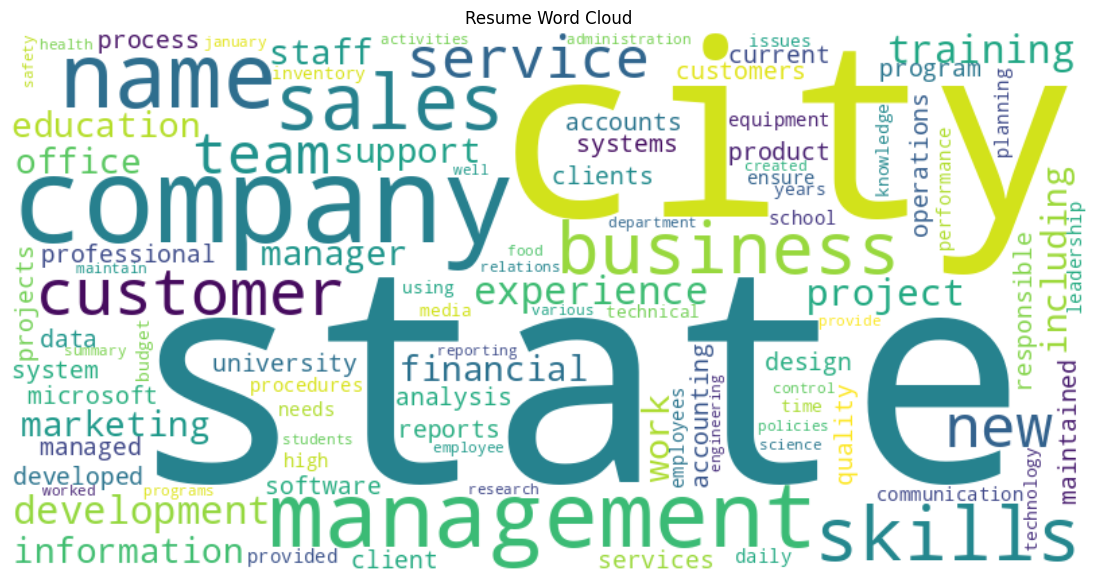

In [11]:
# Word Cloud for Resumes
wc_resume = WordCloud(width=800, height=400, background_color='white')
wc_resume.generate_from_frequencies(resume_top_words)

plt.figure(figsize=(15,7))
plt.imshow(wc_resume, interpolation='bilinear')
plt.axis('off')
plt.title("Resume Word Cloud")
plt.show()



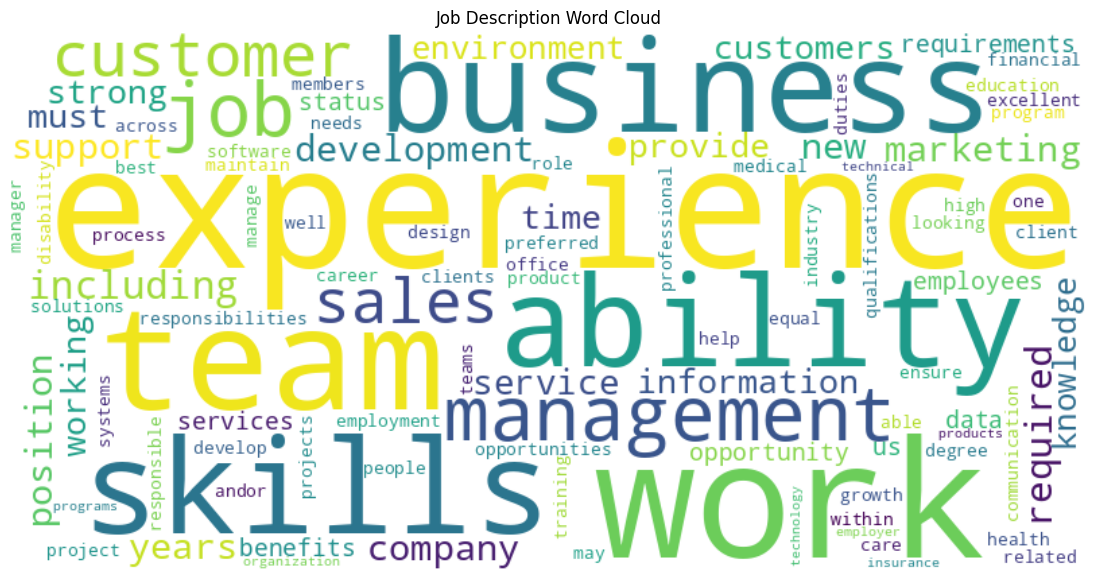

In [12]:
# Word Cloud for Job Descriptions
wc_jd = WordCloud(width=800, height=400, background_color='white')
wc_jd.generate_from_frequencies(jd_top_words)

plt.figure(figsize=(15,7))
plt.imshow(wc_jd, interpolation='bilinear')
plt.axis('off')
plt.title("Job Description Word Cloud")
plt.show()


# 4. Data Cleaning:

In [13]:
def clean_text(text):
    text = str(text).lower()
    text = re.sub(r'[^a-z\s]', '', text)
    text = re.sub(r'\s+', ' ', text).strip()
    return text


In [14]:
resumes_df['clean_resume'] = resumes_df['Resume_str'].apply(clean_text)
jobs_df['clean_jd'] = jobs_df['job_description'].apply(clean_text)

# 5. TF-IDF Vectorization

In [15]:
vectorizer = TfidfVectorizer(max_features=5000)
all_text = resumes_df['clean_resume'].tolist() + jobs_df['clean_jd'].tolist()
vectorizer.fit(all_text)

TfidfVectorizer(max_features=5000)

In [16]:
resume_tfidf = vectorizer.transform(resumes_df['clean_resume'])
jd_tfidf = vectorizer.transform(jobs_df['clean_jd'])

# 6. Cosine Similarity:

In [17]:
similarity_matrix = cosine_similarity(resume_tfidf, jd_tfidf)
print("Similarity matrix shape:", similarity_matrix.shape)

Similarity matrix shape: (2484, 853)


# 7. Evaluation: Find Best Job Match for Each Resume

In [18]:
best_matches = []
for i, resume in enumerate(resumes_df['Resume_str']):
    best_jd_idx = np.argmax(similarity_matrix[i])
    best_score = similarity_matrix[i][best_jd_idx]
    best_matches.append({
        'ID': resumes_df.iloc[i]['ID'],
        'resume_str': resume,
        'best_job_description': jobs_df.iloc[best_jd_idx]['job_description'],
        'job_title': jobs_df.iloc[best_jd_idx]['position_title'],
        'similarity_score': float(best_score)
    })

matches_df = pd.DataFrame(best_matches)
matches_df.head()


,ID,resume_str,best_job_description,job_title,similarity_score
0,16852973,HR ADMINISTRATOR/MARKETING ASSOCIATE\...,human resources generalist aveda institutes l...,Human Resources Generalist,0.427245
1,22323967,"HR SPECIALIST, US HR OPERATIONS ...",specialtycompetency ifs clients markets\nind...,SAP Alliance Marketing Director,0.466732
2,33176873,HR DIRECTOR Summary Over 2...,human resources generalist aveda institutes l...,Human Resources Generalist,0.543851
3,27018550,HR SPECIALIST Summary Dedica...,position overview\n\nat pnc our people are our...,Investment Service Partner – Customer Service ...,0.419646
4,17812897,HR MANAGER Skill Highlights ...,job overview\nprovide support to members of an...,Sr. HR Business Partner (Hybrid/Remote Role),0.600622


/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


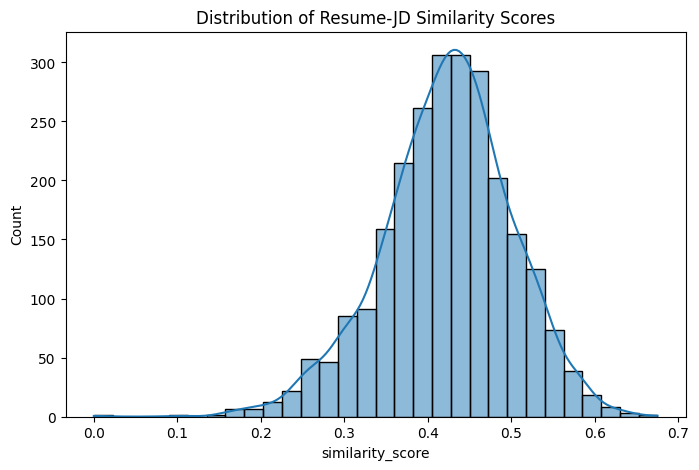

In [19]:
plt.figure(figsize=(8,5))
sns.histplot(matches_df['similarity_score'], bins=30, kde=True)
plt.title("Distribution of Resume-JD Similarity Scores")
plt.show()

In [20]:
strong_matches = matches_df[matches_df['similarity_score'] > 0.5]
print("Number of strong matches:", len(strong_matches))
strong_matches.head()

Number of strong matches: 378


,ID,resume_str,best_job_description,job_title,similarity_score
2,33176873,HR DIRECTOR Summary Over 2...,human resources generalist aveda institutes l...,Human Resources Generalist,0.543851
4,17812897,HR MANAGER Skill Highlights ...,job overview\nprovide support to members of an...,Sr. HR Business Partner (Hybrid/Remote Role),0.600622
7,15375009,HR MANAGER Professional Summa...,human resources generalist aveda institutes l...,Human Resources Generalist,0.544159
11,11480899,HR MANAGER Summary Human...,director human resources\n\nare you looking fo...,"Director, Human Resources",0.576830
12,23155093,HR MANAGER Summary To obta...,job overviewas the leader of sales and custome...,"Manager, Sales and Customer Service",0.521827


# 7. Top Resume Matches:

In [21]:
top_n = 5

# Provide first 2 job descriptions for visualizing evaluation:
for jd_idx in range(2):  
    job_company = jobs_df.iloc[jd_idx]['company_name']
    job_title = jobs_df.iloc[jd_idx]['position_title']
    job_description = clean_text(jobs_df.iloc[jd_idx]['job_description'])
    
    print(f"\n{'='*80}")
    print(f"Job {jd_idx+1}: {job_title} at {job_company}")
    print(f"Job Description: {job_description[:50]}...")
    print(f"{'-'*80}")
    
    # Get similarity scores for this job description
    scores = similarity_matrix[:, jd_idx]
    top_resume_indices = scores.argsort()[::-1][:top_n]
    
    for rank, idx in enumerate(top_resume_indices, 1):
        resume_text = clean_text(resumes_df.iloc[idx]['Resume_str'])
        similarity_score = scores[idx]
        resume_id = resumes_df.iloc[idx]['ID'] 
        print(f"Top {rank} Resume (ID: {resume_id}) | Similarity Score: {similarity_score:.4f}")
        print(f"Resume Text:\n {resume_text[:70]}...\n")



Job 1: Sales Specialist at Google
Job Description: minimum qualifications bachelors degree or equival...
--------------------------------------------------------------------------------
Top 1 Resume (ID: 85421438) | Similarity Score: 0.4094
Resume Text:
 pa media group summary be in a position involving and utilizing my mar...

Top 2 Resume (ID: 17132168) | Similarity Score: 0.3910
Resume Text:
 social engage sales summary my current role represents komlis entire s...

Top 3 Resume (ID: 15535920) | Similarity Score: 0.3805
Resume Text:
 business consultant professional summary it businesssalesoperations po...

Top 4 Resume (ID: 26919036) | Similarity Score: 0.3798
Resume Text:
 consultant account summary this letter is to express my interest in yo...

Top 5 Resume (ID: 20748929) | Similarity Score: 0.3756
Resume Text:
 business development career overview detailoriented professional with ...


Job 2: Apple Solutions Consultant at Apple
Job Description: description as an asc you will b